In [26]:
from importlib import reload
import json
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 422091078071127324
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13336856610618758248
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5588779008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11742072890166847630
physical_device_desc: "device: 0, name: Tesla K20Xm, pci bus id: 0000:00:06.0, compute capability: 3.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 152799329061713978
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
try:
    reload(midiMethods)
    from modules.midiMethods import *
except:
    print('reload failed')
    import modules.midiMethods as midiMethods
    from modules.midiMethods import *
try:
    reload(dataMethods)
    from modules.dataMethods import *
except:
    print('reload failed')
    import modules.dataMethods as dataMethods
    from modules.dataMethods import *
import modules.mlClasses as mlClasses


In [6]:
import modules.models as models
reload(models)
import modules.mlClasses as mlClasses
reload(mlClasses)

<module 'modules.mlClasses' from '/home/ubuntu/music-ml/380-music-representation/modules/mlClasses.py'>

In [75]:
# if needed, read in filenames...
maestro = pd.read_csv('training_data/maestro-v2.0.0withPeriod.csv', index_col=0)
filenames = list(maestro['midi_filename'])

In [ ]:
# or process data set
data_path = 'C:/Users\Andrew/Documents/mlprojects/Datasets/MaestroV2.00/maestro-v2.0.0/'
examples = files2note_bin_examples(data_path, skip=1, speed=0.9)
print(len(examples))

In [322]:
# store examples in json format
with open('training_data/training_data_note_bin_complete.json', 'w') as f:
    json.dump(examples, f)

In [7]:
# or read them in
with open('training_data/training_data_note_bin_complete.json', 'r') as f:
    examples = json.load(f)

In [8]:
# build simple model
# excellent example of recurrent model here https://www.tensorflow.org/tutorials/text/text_generation
hidden_state = 256
lstm_layers = 2
model2 = models.create_model1(hidden_state_size=hidden_state, lstm_layers=lstm_layers)
training_generator = mlClasses.DataGenerator(examples)

Model: "2layerLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 6)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 88)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 10)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 60)      0           input_1[0][0]                    
_________________________________________________________________________________________

In [54]:
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# checkpoint = tf.keras.callbacks.ModelCheckpoint("weights/model1/{epoch:02d}-{train_loss:.2f}.hdf5", monitor='train_loss', verbose=2, save_best_only=True, save_weights_only=True)
history = model2.fit_generator(training_generator, epochs=10)
model2.save_weights('weights/note_bin/model2_10epochs256state2layer.h5')

Epoch 1/10
 48/803 [>.............................] - ETA: 2:48 - loss: 9.9842 - dense_loss: 2.6868 - dense_1_loss: 0.0442 - dense_2_loss: 2.2681 - dense_3_loss: 0.3712 - dense_4_loss: 2.2444 - dense_5_loss: 2.3696 - dense_accuracy: 0.2767 - dense_1_accuracy: 0.9873 - dense_2_accuracy: 0.2811 - dense_3_accuracy: 0.8807 - dense_4_accuracy: 0.3067 - dense_5_accuracy: 0.1825

KeyboardInterrupt: 

In [45]:
# This works just like this:
import modules.models as models
reload(models)    

<module 'modules.models' from '/home/ubuntu/music-ml/380-music-representation/modules/models.py'>

In [14]:
# tf.train.latest_checkpoint('weights\first_attempt')
prediction_model = models.create_model1(batch_size=1, stateful=True, hidden_state_size=hidden_state, lstm_layers=lstm_layers)

Model: "2layerLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(1, 128, 6)]        0                                            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (1, 128, 88)         0           input_4[0][0]                    
__________________________________________________________________________________________________
lambda_19 (Lambda)              (1, 128, 10)         0           input_4[0][0]                    
__________________________________________________________________________________________________
lambda_20 (Lambda)              (1, 128, 60)         0           input_4[0][0]                    
_________________________________________________________________________________________

In [49]:
prediction_model.load_weights('weights/note_bin/model2_10epochs256state2layer.h5')
# temperatures = [0.1] * 6
temperatures = [5, 0.12, 0.12, 0.1, 0.1, 5]
input_notes = [[44,0,0,4,3,20], [48,0,0,4,3,20], [51,0,0,3,3,20],[56,0,5,3,3,20]]
new_seq = models.generate_music(prediction_model, temperatures, input_notes)
ns = [[int(a) for a in note] for note in new_seq]
print(ns)
pm = note_bin2pm(ns)
pm.write(f'midi/model2/{temperatures}b.mid')

[44, 0, 0, 4, 3, 20]
[48, 0, 0, 4, 3, 20]
[51, 0, 0, 3, 3, 20]
[[44, 0, 0, 4, 3, 20], [48, 0, 0, 4, 3, 20], [51, 0, 0, 3, 3, 20], [58, 0, 41, 3, 20, 23], [49, 0, 56, 3, 0, 25], [60, 0, 47, 3, 26, 11], [69, 0, 26, 3, 25, 4], [87, 0, 46, 3, 18, 30], [19, 0, 3, 3, 1, 21], [44, 0, 23, 2, 28, 23], [64, 0, 44, 2, 25, 21], [55, 0, 9, 2, 25, 20], [23, 0, 32, 2, 13, 18], [36, 0, 51, 2, 2, 5], [9, 0, 7, 1, 1, 7], [26, 0, 37, 1, 7, 6], [24, 0, 49, 1, 28, 9], [33, 0, 53, 3, 29, 11], [82, 0, 27, 1, 3, 19], [81, 0, 31, 1, 2, 11], [48, 0, 23, 0, 14, 21], [16, 0, 6, 0, 28, 11], [17, 0, 11, 0, 13, 21], [85, 0, 49, 2, 16, 16], [45, 0, 8, 2, 14, 9], [45, 0, 1, 2, 4, 8], [53, 0, 35, 2, 23, 14], [16, 0, 13, 2, 2, 23], [37, 0, 35, 1, 20, 13], [29, 0, 22, 1, 14, 29], [51, 0, 52, 0, 25, 27], [76, 0, 36, 0, 11, 9], [13, 0, 8, 3, 20, 6], [38, 0, 45, 3, 13, 26], [32, 0, 30, 3, 14, 19], [80, 0, 26, 2, 28, 31], [41, 0, 19, 2, 28, 2], [81, 0, 24, 2, 4, 28], [36, 0, 37, 1, 18, 28], [5, 0, 24, 1, 18, 2], [25, 0, 10, 

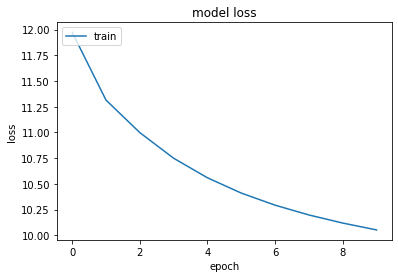

In [29]:
models.plt_metric(history)


In [53]:
examples[330]

[[33, 0, 0, 7, 13, 12],
 [40, 0, 4, 7, 11, 12],
 [37, 0, 1, 7, 10, 12],
 [21, 0, 53, 5, 4, 13],
 [31, 0, 52, 5, 18, 12],
 [19, 0, 4, 5, 16, 5],
 [31, 0, 40, 4, 26, 13],
 [19, 0, 2, 4, 25, 12],
 [45, 1, 40, 3, 0, 17],
 [33, 0, 1, 3, 5, 13],
 [19, 0, 50, 2, 10, 12],
 [31, 0, 0, 2, 10, 12],
 [45, 0, 30, 1, 20, 18],
 [38, 0, 2, 1, 18, 13],
 [33, 0, 2, 1, 23, 13],
 [35, 0, 0, 1, 23, 10],
 [33, 0, 26, 1, 10, 12],
 [21, 0, 0, 4, 5, 17],
 [29, 0, 28, 0, 17, 18],
 [17, 0, 0, 0, 17, 16],
 [29, 0, 35, 3, 4, 15],
 [17, 0, 0, 2, 18, 15],
 [50, 0, 4, 3, 2, 21],
 [38, 0, 1, 3, 1, 16],
 [47, 0, 0, 3, 1, 17],
 [45, 0, 1, 2, 27, 14],
 [38, 1, 26, 1, 18, 15],
 [35, 0, 1, 1, 17, 17],
 [45, 0, 23, 1, 2, 20],
 [33, 0, 2, 1, 3, 16],
 [17, 0, 38, 0, 18, 12],
 [29, 0, 1, 0, 15, 14],
 [45, 0, 11, 0, 6, 15],
 [33, 0, 0, 0, 7, 16],
 [43, 0, 6, 0, 5, 2],
 [45, 0, 6, 5, 28, 20],
 [33, 0, 2, 5, 25, 19],
 [37, 0, 0, 5, 27, 15],
 [43, 0, 2, 5, 26, 1],
 [33, 0, 26, 5, 10, 14],
 [21, 0, 1, 5, 6, 15],
 [16, 0, 37, 4, 23,